In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/packages/__notebook__.ipynb
/kaggle/input/packages/sentence_transformers/nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl
/kaggle/input/packages/sentence_transformers/tqdm-4.66.1-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/huggingface_hub-0.17.3-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/idna-3.4-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/packages/sentence_transformers/joblib-1.3.2-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/transformers-4.34.0-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/Jinja2-3.1.2-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/threadpoolctl-3.2.0-py3-none-any.whl
/kaggle/input/packages/sentence_transformers/tokenizers-0.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
/kaggle/input/packages/sentence_transformers/regex-2023.10.3-cp310-cp310-ma

## Importing neccessary libraries 

In [3]:
# !pip install sentence_transformers --no-index --find-links=file:///kaggle/input/packages/sentence_transformers/
!pip install pyspellchecker --no-index --find-links=file:///kaggle/input/packages/pyspellchecker/ 

Looking in links: file:///kaggle/input/packages/pyspellchecker/
Processing /kaggle/input/packages/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from nltk.corpus import stopwords
from wordcloud import WordCloud

from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import nltk
from nltk import tokenize
import re

from spellchecker import SpellChecker
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold

## Loading and understanding data

In [5]:
df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
df_train_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')

df_test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
df_test_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')

df_sample_submission = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv')

In [6]:
df_train_summaries

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0020ae56ffbf    ebad26   
2     004e978e639e    3b9047   
3     005ab0199905    3b9047   
4     0070c9e7af47    814d6b   
...            ...       ...   
7160  ff7c7e70df07    ebad26   
7161  ffc34d056498    3b9047   
7162  ffd1576d2e1b    3b9047   
7163  ffe4a98093b2    39c16e   
7164  fffbccfd8a08    ebad26   

                                                   text   content   wording  
0     The third wave was an experimentto see how peo...  0.205683  0.380538  
1     They would rub it up with soda to make the sme... -0.548304  0.506755  
2     In Egypt, there were many occupations and soci...  3.128928  4.231226  
3     The highest class was Pharaohs these people we... -0.210614 -0.471415  
4     The Third Wave developed  rapidly because the ...  3.272894  3.219757  
...                                                 ...       ...       ...  
7160  They used all sorts of chemical concoctions to...  0.205683  0.380538  
7161  The lowest classes are slaves and farmers slav... -0.308448  0.048171  
7162             they sorta made people start workin... -1.408180 -0.493603  
7163  An ideal tragety has three elements that make ... -0.393310  0.627128  
7164  The meat would smell sour but the would "rub i...  1.771596  0.547742  

[7165 rows x 5 columns]

In [254]:
df_train_prompts

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [255]:
df_test_summaries

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [256]:
df_test_prompts

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [257]:
df_sample_submission

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [258]:
df_train_summaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


In [259]:
df_train_prompts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


## Evaluation Metrics

For this competition submissions are evaluated using MCRMSE or in other words mean columnwise root mean squared error:
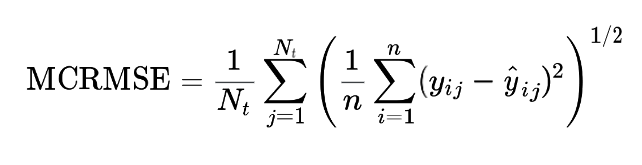

For more details: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview

## Data Preparation 
This step involves two different parts, first of all i need to clean subsets of data (to remove stopwrods, clear punctuation and then to perform EDA on this dataset. Firstly, let's see what is going on in texts to understand what we need to remove, for this, I will take 5 random examples form dataset

In [260]:
for i in range(5):
    rand_number = np.random.randint(0, df_train_summaries.shape[0])
    print(df_train_summaries.loc[rand_number, 'text']+'\n')

Slaves and farmers were at the bottom of the social stucture they did all the hard labor. Next were the Soliers and middle class people, who fought in war and were craftsmen/women and physicians. then there stood the nobles and priests. Nobles were the the pharaoh's assistants they held postd porfited from tributes and paid the pharaohand priests were pleased the gods. And second from the top of the social system is the appointed pharaoh helped amage all the duties of the chief mimister. And finally at the top of the social system is the cheif minister, they were the main rulers and were seeen as gods.

These factories were very unsanitary and so was the food.  "Jonas had told them how the meat that was taken out of pickle would often be found sour, and how they would rub it up with soda to take away the smell."  Even though the quality of the meat wasn't safe for consumption they covered it up. "There was never the least attention paid to what was cut up for sausage; there would come 

In [7]:
# Function for removing and hard preprocess of the text
stop_words = stopwords.words('english')
def prerocess_stopwords(text):
    result = []
    for word in gensim.utils.simple_preprocess(text):
        if(
            word not in gensim.parsing.preprocessing.STOPWORDS and
            word not in stop_words
        ):
            result.append(word)
            
    result = " ".join(result)
    return result


In [8]:
#Function for light preprcocess of the text taken from the lecture
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
    return input

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [9]:
#First of all let's merge two datasets for convenience
df_train = df_train_summaries.merge(df_train_prompts, on = 'prompt_id')

In [10]:
df_train['hard_preprocess_text'] = df_train['text'].map(prerocess_stopwords)
df_train['light_preprocess_text'] = df_train['text'].map(process_light)

In [11]:
class Preprocess_data:
    def __init__(self, df, text_column):
        self.df = df
        self.text_column = text_column
        self.spellchecker = SpellChecker()
    
    def add_num_words(self):
        self.df['num_words'] = self.df[self.text_column].apply(lambda x: len(x.split()))
        
    def add_num_unique_columns(self):
        self.df['num_unqiue_words'] = self.df[self.text_column].apply(lambda x: len(set(x.split())))
        
    def add_num_symbols(self):
        self.df['num_symbols'] = self.df[self.text_column].apply(len)
    
    def add_num_sent(self):
        self.df['num_sent'] = self.df[self.text_column].apply(lambda x: len(x.split('.')))
        
    def add_spell_check(self):
        def check_err_spell(text):
            wordlist = text.split()
            amount_miss = len(list(self.spellchecker.unknown(wordlist)))
            return amount_miss
        
        self.df['spell_err'] = self.df['text'].map(lambda x: check_err_spell(x))
        
    def add_columns(self):
        self.add_num_words()
        self.add_num_unique_columns()
        self.add_num_symbols()
        self.add_num_sent()
        self.add_spell_check()
        return self.df

In [12]:
df_train_hard_preprocess = df_train.drop(["light_preprocess_text"], axis = 1)
df_train_light_preprocess = df_train.drop(["hard_preprocess_text"],axis = 1)

## Exploratory Data Analysis

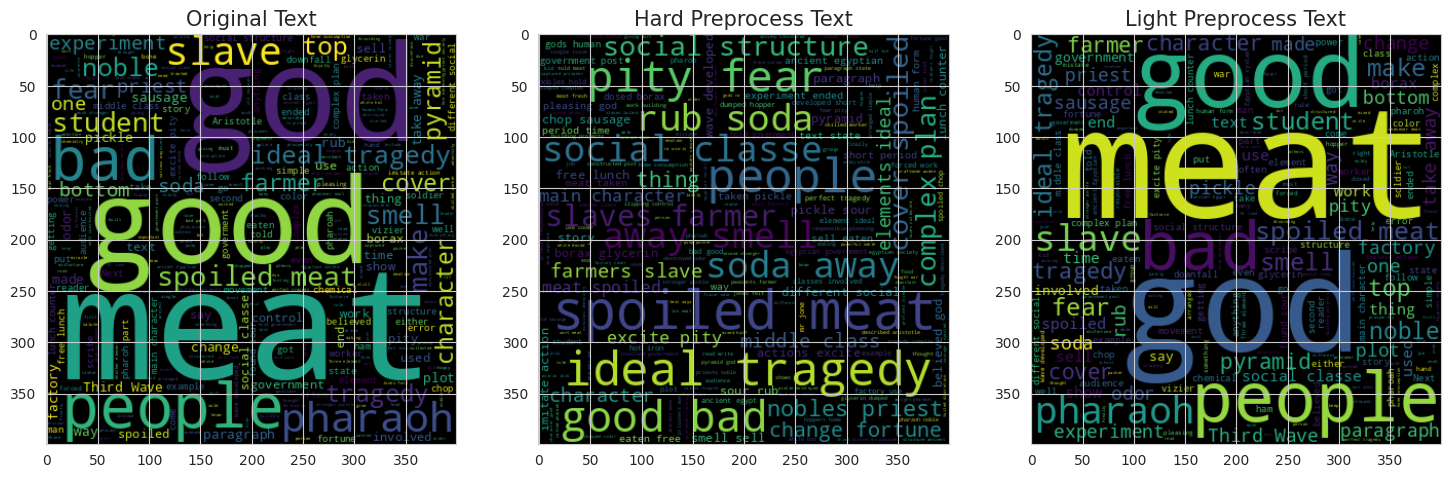

In [267]:
figure, axes = plt.subplots(1,3,figsize = (18,9))

axes[0].set_title('Original Text', fontsize = 15)
wc = WordCloud(max_words = 600 , width = 400, height = 400).generate(" ".join(df_train['text']))
axes[0].imshow(wc, interpolation = 'bilinear')

axes[1].set_title('Hard Preprocess Text', fontsize = 15)
wc1 = WordCloud(max_words = 600 , width = 400, height = 400).generate(" ".join(df_train_hard_preprocess['hard_preprocess_text']))
axes[1].imshow(wc1, interpolation = 'bilinear')

axes[2].set_title("Light Preprocess Text", fontsize = 15)
wc2 = WordCloud(max_words = 600 , width = 400, height = 400).generate(" ".join(df_train_light_preprocess['light_preprocess_text']))
axes[2].imshow(wc2, interpolation = 'bilinear')

plt.show()

We can see that hard Preprocessing of the text has removed big part of words that will be significant for predicting , but in light preprocess we have left then and removed noise from the data.

In [268]:
def plot_words_for_text_group(prompt_title):
    figure, axes = plt.subplots(1,3,figsize = (18, 20))
    
    df_hard_compare = df_train_hard_preprocess[["prompt_title", "hard_preprocess_text"]].groupby("prompt_title").sum()
    hard_text_for_plot = df_hard_compare.loc[prompt_title,'hard_preprocess_text']
    
    df_light_compare = df_train_light_preprocess[["prompt_title", "light_preprocess_text"]].groupby("prompt_title").sum()
    light_preprocess_text = df_light_compare.loc[prompt_title, "light_preprocess_text"]
    
    df_orig_comapre = df_train[["prompt_title", "text"]].groupby("prompt_title").sum()
    original_text = df_orig_comapre.loc[prompt_title, "text"]
    
    axes[0].set_title(f'Original Text for {prompt_title} prompt', fontsize = 10)
    wc = WordCloud(max_words = 600 , width = 800, height = 800).generate(original_text)
    axes[0].imshow(wc, interpolation = 'bilinear')

    axes[1].set_title(f'Hard Preprocess Text for {prompt_title} prompt', fontsize = 10)
    wc1 = WordCloud(max_words = 600 , width = 800, height = 800).generate(hard_text_for_plot)
    axes[1].imshow(wc1, interpolation = 'bilinear')

    axes[2].set_title(f"Light Preprocess Text for {prompt_title} prompt", fontsize = 10)
    wc2 = WordCloud(max_words = 600 , width = 800, height = 800).generate(light_preprocess_text)
    axes[2].imshow(wc2, interpolation = 'bilinear')

    plt.show()


In [269]:
df_train_prompts.loc[:, "prompt_title"]

0                   On Tragedy
1    Egyptian Social Structure
2               The Third Wave
3      Excerpt from The Jungle
Name: prompt_title, dtype: object

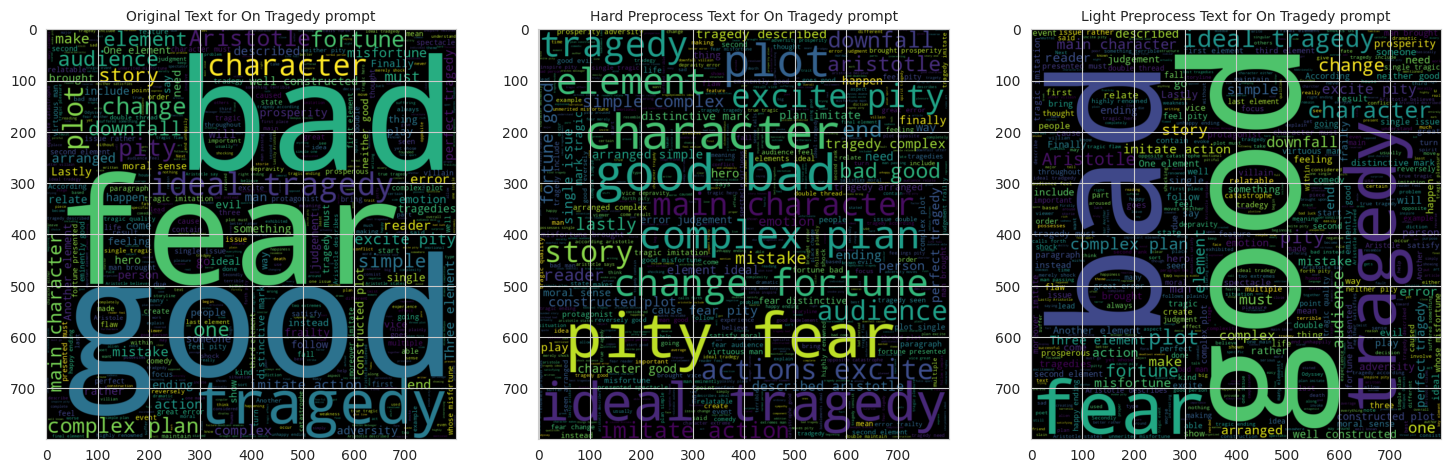

In [270]:
plot_words_for_text_group("On Tragedy")

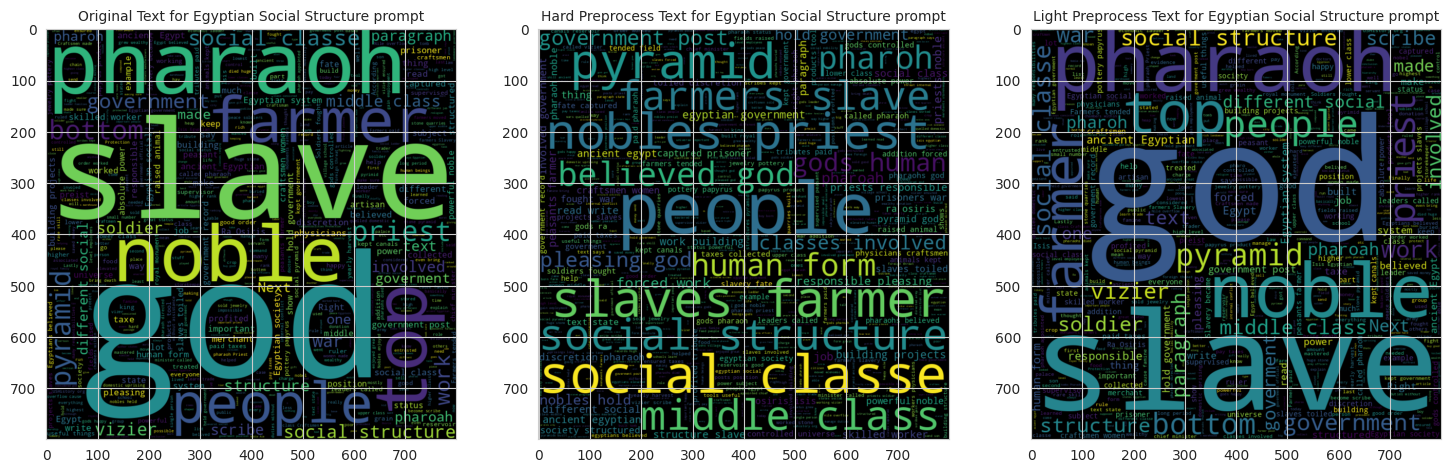

In [271]:
plot_words_for_text_group("Egyptian Social Structure")

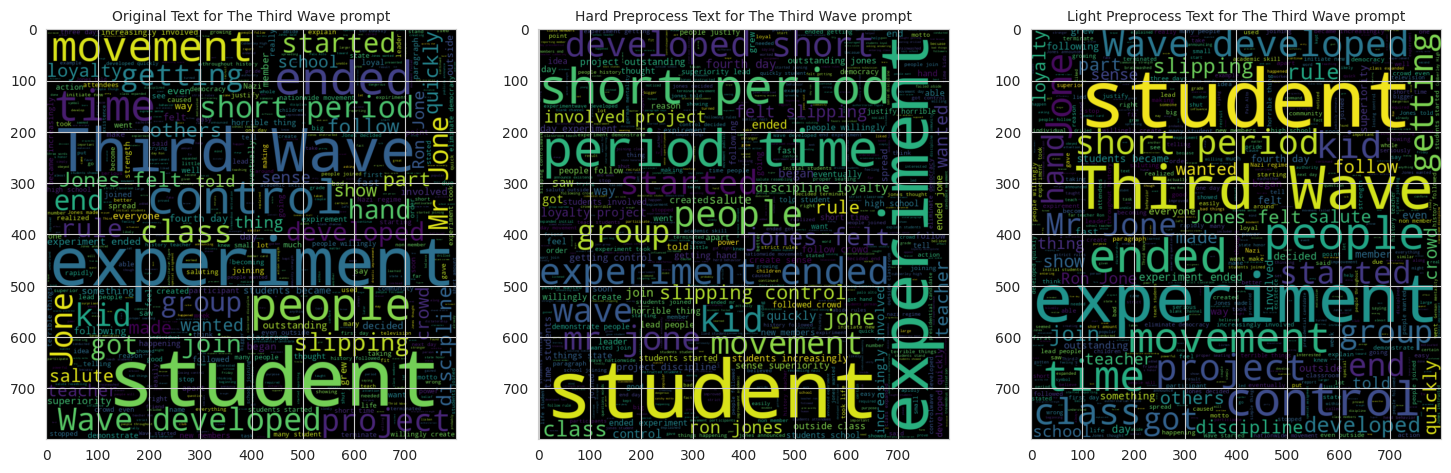

In [272]:
plot_words_for_text_group("The Third Wave")

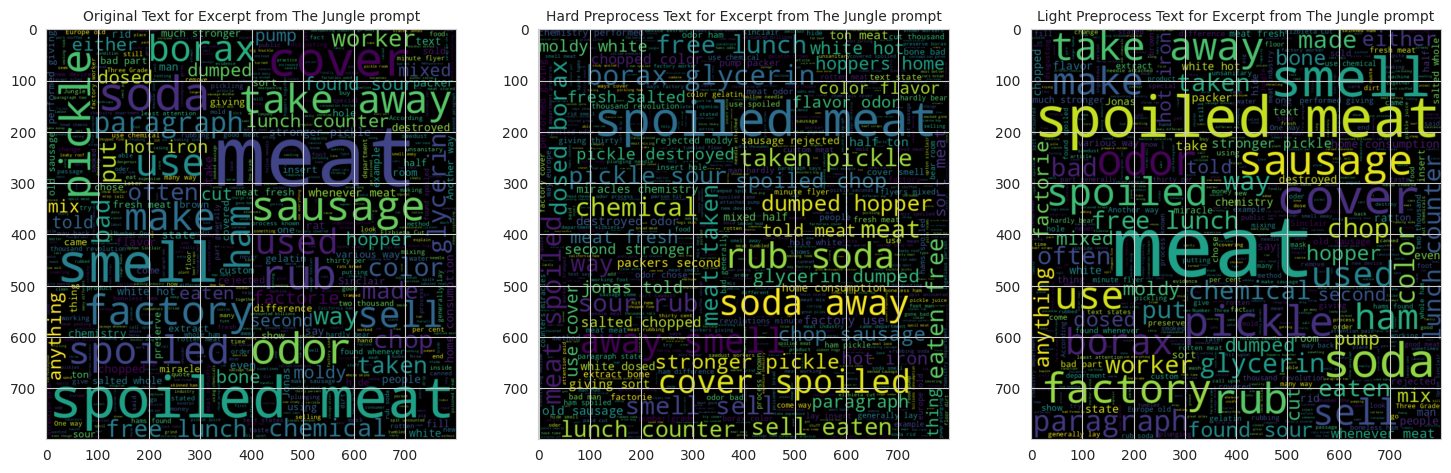

In [273]:
plot_words_for_text_group("Excerpt from The Jungle")

So for hard preprocess text we can see that the most frequantly used words have been changed significantly almost for all prompts title, but in light preprocess text we have remained the most used words from original text, and new one have been added, so light preprocess text will be left for future EDA and prediction

In [13]:
df_train  = df_train_light_preprocess.copy()
df_train = Preprocess_data(df_train, "light_preprocess_text").add_columns()

In [275]:
# sns.set_style('whitegrid')
# figure, axes = plt.subplots(2,2, figsize = (15,12))
# columns_for_plot = ["num_words","num_unqiue_words","num_symbols","num_sent"]
# col = 0
# for ax1 in range(axes.shape[0]):
#     for ax2 in range(axes.shape[1]):
#         axes[ax1, ax2].set_title(f'Distribution of {columns_for_plot[col]}')
#         sns.histplot(df_train[columns_for_plot[col]], ax = axes[ax1, ax2], bins =10)
#         axes[ax1, ax2].set_xlabel('Count')
#         axes[ax1, ax2].set_ylabel('Frequency')
#         col+=1
    

Now let's see the same distributions only for different prompts group

In [276]:
# fig, axes = plt.subplots(2,2,figsize = (20,15))

# columns_for_plot = ["num_words","num_unqiue_words","num_symbols","num_sent"]
# col = 0
# for ax1 in range(axes.shape[0]):
#     for ax2 in range(axes.shape[1]):
#         axes[ax1,ax2].set_title(f'{columns_for_plot[col]} by Prompt')
#         data_for_plot = df_train[[columns_for_plot[col],'prompt_title']]
#         sns.boxplot(x = data_for_plot['prompt_title'], y =data_for_plot[columns_for_plot[col]], ax = axes[ax1, ax2])
#         col+=1


So, we examined that all categories don't have big difference between their values. Now we will try to investigate link between these 4 columns and target columns

In [277]:
# fig, axes = plt.subplots(1,2, figsize = (20,8))

# columns_for_plot = ['wording', 'content']
# for ax in range(axes.shape[0]):
#         axes[ax].set_title(f'{columns_for_plot[ax]} by Prompt')
#         data_for_plot = df_train[[columns_for_plot[ax],'prompt_title']]
#         sns.boxplot(x = data_for_plot['prompt_title'], y =data_for_plot[columns_for_plot[ax]], ax = axes[ax])

Here we can observe that median of wording score in category "The Third Wave" is bigger than in other categories, on other hand content score for this column has the same median as in other columns

In [278]:
# fig, axes = plt.subplots(1,2,figsize=(14,6)) 

# axes[0].set_title('Wording distibution vs number of words')
# sns.kdeplot(x = df_train['num_words'], y =df_train['wording'], ax = axes[0],fill = True, alpha=.8, color = 'r')

# axes[1].set_title('Content distibution vs number of words')
# sns.kdeplot(x = df_train['num_words'], y = df_train['content'], ax = axes[1], fill = True, alpha=.8, color = 'g')

# corr_cont_num = df_train['content'].corr(df_train['num_words'])
# corr_word_num = df_train['wording'].corr(df_train['num_words'])

# print(f'Correlation between Content and number of words: {corr_cont_num }')
# print(f'Correlation between Wording and number of words: {corr_word_num }')

So in both cases we get positive correlation with scores for wording and content. However in case of Content column it is more positive than in content column. Overall, texts with more words tends to have greater score for wording and content category

In [279]:
# fig, axes = plt.subplots(1,2,figsize=(14,6)) 

# axes[0].set_title('Wording distibution vs number of unique words')
# sns.kdeplot(x = df_train['num_unqiue_words'], y =df_train['wording'], ax = axes[0],fill = True, alpha=.8, color = 'r')

# axes[1].set_title('Content distibution vs number of unique words')
# sns.kdeplot(x = df_train['num_unqiue_words'], y = df_train['content'], ax = axes[1], fill = True, alpha=.8, color = 'g')

# corr_cont_num = df_train['content'].corr(df_train['num_unqiue_words'])
# corr_word_num = df_train['wording'].corr(df_train['num_unqiue_words'])

# print(f'Correlation between Content and number of unique words: {corr_cont_num }')
# print(f'Correlation between Wording and number of unique words: {corr_word_num }')

Ther is a positive correlation between the number of unique words and content score, indicating that summaries with greater variety of words tend to have greater score for content part. Similar situation can be observed with wording score, however in this case correaltion not so strong as in situation with the content score.

In [280]:
# And last but not least to check correlation with spell_err feature of the dataset 
# fig, axes = plt.subplots(1,2,figsize=(14,6)) 

# axes[0].set_title('Wording distibution vs number of spelling errors in text')
# sns.kdeplot(x = df_train['spell_err'], y =df_train['wording'], ax = axes[0],fill = True, alpha=.8, color = 'r')

# axes[1].set_title('Content distibution vs number of spelling errors in text')
# sns.kdeplot(x = df_train['spell_err'], y = df_train['content'], ax = axes[1], fill = True, alpha=.8, color = 'g')

# corr_cont_num = df_train['content'].corr(df_train['spell_err'])
# corr_word_num = df_train['wording'].corr(df_train['spell_err'])

# print(f'Correlation between Content and number of spelling errors: {corr_cont_num }')
# print(f'Correlation between Wording and number of spelling errors: {corr_word_num }')

Here we can see the same good correlation with Content column and not so strong correlation with content column, but we can try to use this column for predicting wording grade of the text

In [281]:
# # And finnaly, I will comapre the distributons of wording and content scores
# fig, axes = plt.subplots(1,2, figsize = (15,6))

# axes[0].set_title('Distribution of the Wording Scores')
# sns.histplot(df_train['wording'],color='skyblue', edgecolor='black', ax = axes[0], bins = 30)

# axes[1].set_title('Distribution of the Content Scores')
# sns.histplot(df_train['content'],color='skyblue', edgecolor='black', ax = axes[1], bins = 30);

Content Score Distribution is normal but slighylt left-skewed with a peak a bit below zero. This shows us that siginificant number of summaries have received negative score.

Wording distribution is also similar to normal, and left-skewed, with most of the scores below zero. 

## Modeling

So for modeling wording and count score we need to use different features, for predciting wording score we don't need features which connected with prompt charachteristic and we can try to add columns which connected with spelling of the text, but for predicting content column we need to use left features connected with prompt.

In [282]:
#Now i will create datasets for training model for predicting content score and for for predicting wording score
# df_content = df_train[['light_preprocess_text', 'num_words', 'num_unqiue_words', 'num_symbols', 'num_sent', 'prompt_title']]
# df_wording = df_train[['light_preprocess_text','spell_err', 'prompt_title']]

# y_cont = df_train['content']
# y_wording = df_train['wording']

In the last homework XGBRegressor has shown the best socre of MCRMSE, so we will use it in this assignment also, i will start with bag of words as baseline model. 
Also, in the test set it will be new prompts, so for training we can use only three prompts and for validation only one prompt

In [283]:
# #Splitting for traingn and validation set 
# title_for_validation = "The Third Wave"
# filter_for_cont = df_content['prompt_title'] != title_for_validation
# filter_for_wording = df_wording['prompt_title'] != title_for_validation

# X_cont_train, X_cont_test = df_content[filter_for_cont].drop('prompt_title', axis = 1), df_content[~filter_for_cont].drop('prompt_title', axis = 1)
    
# X_wording_train, X_wording_test = df_wording[filter_for_wording].drop('prompt_title', axis = 1), df_wording[~filter_for_wording].drop('prompt_title', axis = 1)

# y_cont_train = y_cont[filter_for_cont]
# y_cont_test  = y_cont[~filter_for_cont]

# y_wording_train = y_wording[filter_for_wording]
# y_wording_test = y_wording[~filter_for_wording]

In [284]:
# def vectorize_text_col(df, text_col, vectorizer):
#     res = vectorizer.transform(df[text_col])
#     df = df.drop(text_col,axis = 1)
#     new_df = pd.concat([df, pd.DataFrame(res.toarray(), columns = vectorizer.get_feature_names_out())], axis = 1, join = "outer")
#     return new_df
# #Splitting for training and validation set 
# title_for_validation = "The Third Wave"
# filter_for_cont = df_content['prompt_title'] != title_for_validation
# filter_for_wording = df_wording['prompt_title'] != title_for_validation

# X_cont_train, X_cont_test = df_content[filter_for_cont].drop('prompt_title', axis = 1), df_content[~filter_for_cont].drop('prompt_title', axis = 1)
    
# X_wording_train, X_wording_test = df_wording[filter_for_wording].drop('prompt_title', axis = 1), df_wording[~filter_for_wording].drop('prompt_title', axis = 1)

# y_cont_train = y_cont[filter_for_cont]
# y_cont_test  = y_cont[~filter_for_cont]

# y_wording_train = y_wording[filter_for_wording]
# y_wording_test = y_wording[~filter_for_wording]

# cont_vect = CountVectorizer(max_features = 7500).fit(X_cont_train['light_preprocess_text'])
# X_cont_train = vectorize_text_col(X_cont_train.reset_index(drop = True),"light_preprocess_text", cont_vect)
# X_cont_test = vectorize_text_col(X_cont_test.reset_index(drop = True),"light_preprocess_text", cont_vect)

# word_vect = CountVectorizer(max_features = 7500).fit(X_wording_train['light_preprocess_text'])
# X_wording_train  = vectorize_text_col(X_wording_train.reset_index(drop = True), "light_preprocess_text", word_vect)
# X_wording_test = vectorize_text_col(X_wording_test.reset_index(drop=True), "light_preprocess_text", word_vect)

# cont_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# cont_pred.fit(X_cont_train, y_cont_train)

# word_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# word_pred.fit(X_wording_train, y_wording_train)

# cont_prediction = cont_pred.predict(X_cont_test)
# word_prediction = word_pred.predict(X_wording_test)

# mcrmse = (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
#              + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

# print(f'MCRMSE for XGBregressor model with Count Vectorization: {mcrmse}')

Because of high dimensiolaty of the data i have set n_estimators to 80, and also restricted percent of features used by each tree in the process of training to 40 percent. On the next step I will try to use Tf-IdVectrorizer, maybe with this vectorizer i will have better results. The last on what i want to add about this step is the best size of max_features used in CountVectorizer is something between 7000 and 8000.

In [285]:
# def vectorize_text_col(df, text_col, vectorizer):
#     res = vectorizer.transform(df[text_col])
#     df = df.drop(text_col,axis = 1)
#     new_df = pd.concat([df, pd.DataFrame(res.toarray(), columns = vectorizer.get_feature_names_out())], axis = 1, join = "outer")
#     return new_df

# #Splitting for training and validation set 
# title_for_validation = "The Third Wave"
# filter_for_cont = df_content['prompt_title'] != title_for_validation
# filter_for_wording = df_wording['prompt_title'] != title_for_validation

# X_cont_train, X_cont_test = df_content[filter_for_cont].drop('prompt_title', axis = 1), df_content[~filter_for_cont].drop('prompt_title', axis = 1)
    
# X_wording_train, X_wording_test = df_wording[filter_for_wording].drop('prompt_title', axis = 1), df_wording[~filter_for_wording].drop('prompt_title', axis = 1)

# y_cont_train = y_cont[filter_for_cont]
# y_cont_test  = y_cont[~filter_for_cont]

# y_wording_train = y_wording[filter_for_wording]
# y_wording_test = y_wording[~filter_for_wording]

# cont_vect_tfidf = TfidfVectorizer(analyzer='word',
#             ngram_range=(1, 1),
#             lowercase=True,
#             min_df=1,
#             max_features=30000).fit(X_cont_train['light_preprocess_text'])

# X_cont_train = vectorize_text_col(X_cont_train.reset_index(drop = True),"light_preprocess_text", cont_vect_tfidf)
# X_cont_test = vectorize_text_col(X_cont_test.reset_index(drop = True),"light_preprocess_text", cont_vect_tfidf)

# word_vect_tfidf = TfidfVectorizer(analyzer='word',
#             ngram_range=(1, 1),
#             lowercase=True,
#             min_df=1,
#             max_features=30000).fit(X_wording_train['light_preprocess_text'])

# X_wording_train  = vectorize_text_col(X_wording_train.reset_index(drop = True), "light_preprocess_text", word_vect_tfidf)
# X_wording_test = vectorize_text_col(X_wording_test.reset_index(drop=True), "light_preprocess_text", word_vect_tfidf)

# cont_pred_tfidf_xgb = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# cont_pred_tfidf_xgb.fit(X_cont_train, y_cont_train)

# word_pred_tfidf_xgb = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# word_pred_tfidf_xgb.fit(X_wording_train, y_wording_train)

# cont_prediction = cont_pred_tfidf_xgb.predict(X_cont_test)
# word_prediction = word_pred_tfidf_xgb.predict(X_wording_test)

# mcrmse = (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
#              + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

# print(f'MCRMSE for XGBregressor model with Tf-Idf Vectorization: {mcrmse}')

With default parameters Tf-Idf vectorizer has shown not significant improvment, i will try to tune parametres manually and check if it helps to improve model perfomance. Adding parameters ngram_range and stopwrods has only spoilt the prediction, because the mcrmse has increased to the 0.99, after removing ngram_range the perfomace of the model has increased to the 0.93, now i will try to increase the parametr of the max_features to see the result, so after increasing max_features to 30000 I have obtained the best result for tf-idf. In the end of this step I want to add that it is logicaly that after removing stopwords I have obtained worse model, because, as we have seen on the stage of EDA removing of stopwords, only make situation of understanding text worse and adding ngram_range maybe caused the overfitting of the model. So with TfIdf i will end with small imporvement to 0.881. Let's try to use Sentence Embedings like SpaCy and BERT Sentence Transformer.

In [286]:
# nlp = spacy.load("en_core_web_md")
# new_df = df_train['light_preprocess_text'].map(lambda x: nlp(x).vector)
# vectorized_text_spacy = new_df.apply(pd.Series)

In [287]:
# df_content_spacy = pd.concat([vectorized_text_spacy, df_content.drop(['prompt_title','light_preprocess_text'], axis = 1)], axis = 1, join = "outer")
# df_wording_spacy = pd.concat([vectorized_text_spacy, df_wording.drop(['light_preprocess_text', 'prompt_title'], axis = 1)], axis = 1, join = "outer")

# #Splitting for training and validation set 
# title_for_validation = "The Third Wave"
# filter_for_cont = df_content['prompt_title'] != title_for_validation
# filter_for_wording = df_wording['prompt_title'] != title_for_validation

# X_cont_train, X_cont_test = df_content_spacy[filter_for_cont], df_content_spacy[~filter_for_cont]
    
# X_wording_train, X_wording_test = df_wording_spacy[filter_for_wording], df_wording_spacy[~filter_for_wording]

# y_cont_train = y_cont[filter_for_cont]
# y_cont_test  = y_cont[~filter_for_cont]

# y_wording_train = y_wording[filter_for_wording]
# y_wording_test = y_wording[~filter_for_wording]

# cont_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# cont_pred.fit(X_cont_train, y_cont_train)

# word_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# word_pred.fit(X_wording_train, y_wording_train)

# cont_prediction = cont_pred.predict(X_cont_test)
# word_prediction = word_pred.predict(X_wording_test)

# mcrmse = (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
#              + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

# print(f'MCRMSE for XGBregressor model with Spacy Sentence Embeding: {mcrmse}')

After using SpaCy we have get even worse result, let's try to use BERT and see results

In [288]:
# sent_tr = SentenceTransformer("all-MiniLM-L6-v2")
# sent_tr_text = df_train['light_preprocess_text'].map(lambda x: sent_tr.encode(x))

In [289]:
# sent_tr_text = sent_tr_text.apply(pd.Series)

In [290]:
# df_content_spacy = pd.concat([sent_tr_text, df_content.drop(['prompt_title','light_preprocess_text'], axis = 1)], axis = 1, join = "outer")
# df_wording_spacy = pd.concat([sent_tr_text, df_wording.drop(['light_preprocess_text', 'prompt_title'], axis = 1)], axis = 1, join = "outer")

# #Splitting for training and validation set 
# title_for_validation = "The Third Wave"
# filter_for_cont = df_content['prompt_title'] != title_for_validation
# filter_for_wording = df_wording['prompt_title'] != title_for_validation

# X_cont_train, X_cont_test = df_content_spacy[filter_for_cont], df_content_spacy[~filter_for_cont]
    
# X_wording_train, X_wording_test = df_wording_spacy[filter_for_wording], df_wording_spacy[~filter_for_wording]

# y_cont_train = y_cont[filter_for_cont]
# y_cont_test  = y_cont[~filter_for_cont]

# y_wording_train = y_wording[filter_for_wording]
# y_wording_test = y_wording[~filter_for_wording]

# cont_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# cont_pred.fit(X_cont_train, y_cont_train)

# word_pred = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
# word_pred.fit(X_wording_train, y_wording_train)

# cont_prediction = cont_pred.predict(X_cont_test)
# word_prediction = word_pred.predict(X_wording_test)

# mcrmse = (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
#              + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

# print(f'MCRMSE for XGBregressor model with BERT sentence Embeding: {mcrmse}')

So TfIdf has shown the best result let's tune models for this vectorization and submit results

In [291]:
# def vectorize_text_col(df, text_col, vectorizer):
#     res = vectorizer.transform(df[text_col])
#     df = df.drop(text_col,axis = 1)
#     new_df = pd.concat([df, pd.DataFrame(res.toarray(), columns = vectorizer.get_feature_names_out())], axis = 1, join = "outer")
#     return new_df

# cont_vect = TfidfVectorizer(analyzer='word',
#             ngram_range=(1, 1),
#             lowercase=True,
#             min_df=1,
#             max_features=30000).fit(X_cont_train['light_preprocess_text'])

# X_cont_train = vectorize_text_col(X_cont_train.reset_index(drop = True),"light_preprocess_text", cont_vect)
# X_cont_test = vectorize_text_col(X_cont_test.reset_index(drop = True),"light_preprocess_text", cont_vect)

# word_vect = TfidfVectorizer(analyzer='word',
#             ngram_range=(1, 1),
#             lowercase=True,
#             min_df=1,
#             max_features=30000).fit(X_wording_train['light_preprocess_text'])

# X_wording_train  = vectorize_text_col(X_wording_train.reset_index(drop = True), "light_preprocess_text", word_vect)
# X_wording_test = vectorize_text_col(X_wording_test.reset_index(drop=True), "light_preprocess_text", word_vect)

In [292]:
# cont_grid_search = GridSearchCV(XGBRegressor(), 
#                                param_grid = {"n_estimators":np.arange(80,120,20),
#                                              "colsample_bytree":np.linspace(0.3,0.8,3),
#                                              "learning_rate":np.linspace(0.01, 0.1, 3)},
#                                cv = 5)
# cont_grid_search.fit(X_cont_train, y_cont_train)

# word_grid_search = GridSearchCV(XGBRegressor(), 
#                                param_grid = {"n_estimators":np.arange(80,120,20),
#                                              "colsample_bytree":np.linspace(0.3,0.8,3),
#                                              "learning_rate":np.linspace(0.01, 0.1, 3)},
#                                cv = 5)
# word_grid_search.fit(X_wording_train, y_wording_train)

# best_cont_pred = cont_grid_search.best_estimator_
# best_word_pred = word_grid_search.best_estimator_

# cont_prediction = best_cont_pred.predict(X_cont_test)
# word_prediction = best_word_pred.predict(X_wording_test)

# mcrmse = (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
#              + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

# print(f'MCRMSE for XGBregressor model with Tf-Idf Vectorization: {mcrmse}')
# print(f"Best Parameters for content model {cont_grid_search.best_params_}")
# print(f"Best Parameters for wording model {word_grid_search.best_params_}")

So we have get the final results after tuning model, unfortunately we have received worse results than with standart parameters, so i will submit results with model, which has been trained firstly with TfIdf Vectroizer

In [293]:
# features_cont = ['text', "num_words","num_unqiue_words","num_symbols","num_sent"]
# features_word = ['text', 'spell_err']

# df_test = df_test_summaries.merge(df_test_prompts, on = 'prompt_id')
# df_test = Preprocess_data(df_test, "text").add_columns()
# X_test_cont_sub = df_test[features_cont]
# X_test_word_sub = df_test[features_word]

# X_test_cont_sub = vectorize_text_col(X_test_cont_sub.reset_index(drop = True),"text", cont_vect_tfidf)
# X_test_word_sub = vectorize_text_col(X_test_word_sub.reset_index(drop=True), "text", word_vect_tfidf)

# cont_submit = cont_pred_tfidf_xgb.predict(X_test_cont_sub)
# word_submit = word_pred_tfidf_xgb.predict(X_test_word_sub)

# df_sample_submission['content'] = cont_submit
# df_sample_submission['wording'] = word_submit

So let's add Ridge Regression model for checking the correlation of metrics increases betweeen Ridge model and XGBRegressor model

## Testing Validation techniques

Firstly I will try to use simple simple on the validation and train datasets

In [14]:
features_cont = ['light_preprocess_text', "num_words","num_unqiue_words","num_symbols","num_sent"]
features_word = ['light_preprocess_text', 'spell_err']
df_content = df_train[features_cont]
df_wording = df_train[features_word]

y_cont = df_train['content']
y_wording = df_train['wording']

In [20]:
def vectorize_text_col(df, text_col, vectorizer):
    res = vectorizer.transform(df[text_col])
    df = df.drop(text_col,axis = 1)
    new_df = pd.concat([df, pd.DataFrame(res.toarray(), columns = vectorizer.get_feature_names_out())], axis = 1, join = "outer")
    return new_df

def mcrmse (cont_prediction, y_cont_test, word_prediction, y_wording_test):
    return (np.sqrt(mean_squared_error(cont_prediction, y_cont_test))
             + np.sqrt(mean_squared_error(word_prediction, y_wording_test)))/2

In [295]:
X_content_train, X_content_test, y_content_train, y_content_test = train_test_split(df_content, y_cont, test_size = 0.33, random_state = 54)
X_word_train, X_word_test, y_word_train, y_word_test = train_test_split(df_wording, y_wording, test_size = 0.33, random_state = 54)

cont_vect = TfidfVectorizer(analyzer='word',
            ngram_range=(1, 1),
            lowercase=True,
            min_df=1,
            max_features=30000).fit(X_content_train['light_preprocess_text'])

X_content_train = vectorize_text_col(X_content_train.reset_index(drop = True),"light_preprocess_text", cont_vect)
X_content_test = vectorize_text_col(X_content_test.reset_index(drop = True),"light_preprocess_text", cont_vect)

word_vect = TfidfVectorizer(analyzer='word',
            ngram_range=(1, 1),
            lowercase=True,
            min_df=1,
            max_features=30000).fit(X_word_train['light_preprocess_text'])

X_word_train  = vectorize_text_col(X_word_train.reset_index(drop = True), "light_preprocess_text", word_vect)
X_word_test = vectorize_text_col(X_word_test.reset_index(drop=True), "light_preprocess_text", word_vect)

xgbreg_cont = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
xgbreg_cont.fit(X_content_train, y_content_train)

xgbreg_word = XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)
xgbreg_word.fit(X_word_train, y_word_train)

cont_pred = xgbreg_cont.predict(X_content_test)
word_pred = xgbreg_word.predict(X_word_test)

mcrmse_xgbreg = mcrmse(cont_pred, y_content_test, word_pred, y_word_test)

ridge_cont = Ridge()
ridge_cont.fit(X_content_train, y_content_train)

ridge_word = Ridge()
ridge_word.fit(X_word_train, y_word_train)

cont_pred_ridge = ridge_cont.predict(X_content_test)
word_pred_ridge = ridge_word.predict(X_word_test)

mcrmse_ridge = mcrmse(cont_pred_ridge, y_content_test, word_pred_ridge, y_word_test)

print(f"MCRMSE obtained for Ridge regression {mcrmse_ridge}")
print(f"MCRMSE obtained for XGBRegressor {mcrmse_xgbreg}")

MCRMSE obtained for Ridge regression 0.6200390138066849
MCRMSE obtained for XGBRegressor 0.6013273299314466


Important Note: Version 14 is submission for train test split for XGBRegressor

So in the LB I have obtained next results 

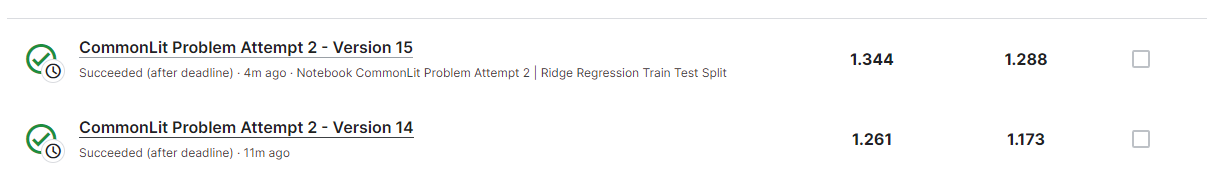

Firstly, I want to metion that difference between models score in LB and in validation process here is siginificant, so for reducing difference between these scores we can use GroupKFold, because in the test set we have big amount of unknown prompt title so we can try to imitate validation process. Secondly, even for simple train-test split we can observe correlations of metrics increases between experiments.


In [15]:
df_test = df_test_summaries.merge(df_test_prompts, on = 'prompt_id')
df_test = Preprocess_data(df_test, "text").add_columns()

features_cont_test = list(map(lambda x: x.replace('light_preprocess_text', 'text'), features_cont))
features_word_test = list(map(lambda x: x.replace('light_preprocess_text', 'text'), features_word))
df_test_cont = df_test[features_cont_test].copy()
df_test_word = df_test[features_word_test].copy()

# df_test_cont_sub = vectorize_text_col(df_test_cont, "text", cont_vect)
# df_test_word_sub = vectorize_text_col(df_test_word, "text", word_vect)

# df_cont_pred_xgbreg = xgbreg_cont.predict(df_test_cont_sub)
# df_word_pred_xgbreg = xgbreg_word.predict(df_test_word_sub)

# df_xgbreg_sub = df_sample_submission.copy()
# df_xgbreg_sub['content'] = df_cont_pred_xgbreg
# df_xgbreg_sub['wording'] = df_word_pred_xgbreg
# df_xgbreg_sub.to_csv('submission.csv', index=False)

# df_cont_pred_ridge = ridge_cont.predict(df_test_cont_sub)
# df_word_pred_ridge = ridge_word.predict(df_test_word_sub)

# df_ridge_sub = df_sample_submission.copy()
# df_ridge_sub['content'] = df_cont_pred_ridge
# df_ridge_sub['wording'] = df_word_pred_ridge
# df_ridge_sub.to_csv('submission.csv', index=False)

In [297]:
def test_val_tech(validation = "KFold"):
    results = []
    test_results = []
    models = {"Ridgre Regression": [Ridge(),Ridge()],
              "XGBReregssor": [XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1), 
                               XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)]
             }
    for model_name, model in models.items():
        scores = []
        vect = [TfidfVectorizer(analyzer='word',
                ngram_range=(1, 1),
                lowercase=True,
                min_df=1,
                max_features=30000),
                TfidfVectorizer(analyzer='word',
                        ngram_range=(1, 1),
                        lowercase=True,
                        min_df=1,
                        max_features=30000)]
        if validation == "KFold":
            cv = KFold(n_splits = 5, shuffle = True, random_state = 54)
        elif validation == "Stratified":
            cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 54)
        for train_ind, test_ind in cv.split(df_content, y_cont):
            X_cont_train, X_word_train, X_cont_test, X_word_test = df_content.iloc[train_ind], df_wording.iloc[train_ind], df_content.iloc[test_ind], df_wording.iloc[test_ind]
            y_cont_train, y_word_train, y_cont_test, y_word_test = y_cont.iloc[train_ind], y_wording.iloc[train_ind], y_cont.iloc[test_ind], y_wording.iloc[test_ind]

            vect[0].fit(X_cont_train['light_preprocess_text'])

            X_cont_train = vectorize_text_col(X_cont_train.reset_index(drop = True),"light_preprocess_text", vect[0])
            X_cont_test = vectorize_text_col(X_cont_test.reset_index(drop = True),"light_preprocess_text", vect[0])

            vect[1].fit(X_word_train['light_preprocess_text'])

            X_word_train  = vectorize_text_col(X_word_train.reset_index(drop = True), "light_preprocess_text", vect[1])
            X_word_test = vectorize_text_col(X_word_test.reset_index(drop=True), "light_preprocess_text", vect[1])

            model[0].fit(X_cont_train, y_cont_train)
            model[1].fit(X_word_train, y_word_train)

            cont_pred = model[0].predict(X_cont_test)
            word_pred = model[1].predict(X_word_test)

            scores.append(mcrmse(cont_pred, y_cont_test, word_pred, y_word_test))

        scores = np.array(scores)
        avg_score = round(scores.mean(), 4)
        std_score = round(scores.std(), 4)
        min_score = round(scores.min(), 4)
        max_score = round(scores.max(), 4)
        score_lower_bound = round(avg_score - 3*std_score, 4)
        score_higher_bound = round(avg_score + 3*std_score, 4)
        results.append({
            'experiment': model_name,
            'mcrmse_avg': avg_score,
            'mcrmse_std': std_score,
            'mcrmse_min': min_score,
            'mcrmse_max': max_score,
            'mcrmse_lower_bound_estimation': score_lower_bound,
            'mcrmse_higher_bound_estimation': score_higher_bound
        })

        df_test_cont_sub = vectorize_text_col(df_test_cont, "text", vect[0])
        df_test_word_sub = vectorize_text_col(df_test_word, "text", vect[1])

        cont_pred_test  = model[0].predict(df_test_cont_sub)
        word_pred_test = model[1].predict(df_test_word_sub)

        test_results.append(
                    {f"{model_name}_cont_pred":cont_pred_test,
                     f"{model_name}_word_pred":word_pred_test}
        )

    results = pd.DataFrame(results)
    return results, test_results

In [298]:
result, test_res = test_val_tech()

In [299]:
# df_ridge_sub = df_sample_submission.copy()
# df_ridge_sub['content'] = test_res[0]["Ridgre Regression_cont_pred"]
# df_ridge_sub['wording'] = test_res[0]["Ridgre Regression_word_pred"]
# df_ridge_sub.to_csv('submission.csv', index=False)

# df_xgbreg_sub = df_sample_submission.copy()
# df_xgbreg_sub['content'] = test_res[1]["XGBReregssor_cont_pred"]
# df_xgbreg_sub['wording'] = test_res[1]["XGBReregssor_word_pred"]
# df_xgbreg_sub.to_csv('submission.csv', index=False)

In [300]:
result

experiment  mcrmse_avg  mcrmse_std  mcrmse_min  mcrmse_max  \
0  Ridgre Regression      0.5946      0.0197      0.5641      0.6208   
1       XGBReregssor      0.5778      0.0159      0.5580      0.5939   

   mcrmse_lower_bound_estimation  mcrmse_higher_bound_estimation  
0                         0.5355                          0.6537  
1                         0.5301                          0.6255

So we have received results very similar to the last submission. MCRMSE for both models is higher than mcrmse_higher_bound_estimation, so that not good for the validation, we also have big difference between score on the LB and validation result. In this situaton we also have correlations of metrics increases between experiments. And in this case metrics on the LB worse than metrics on the previous experiment. Let's try Group KFold maybe in this case we will reduce difference between metrics

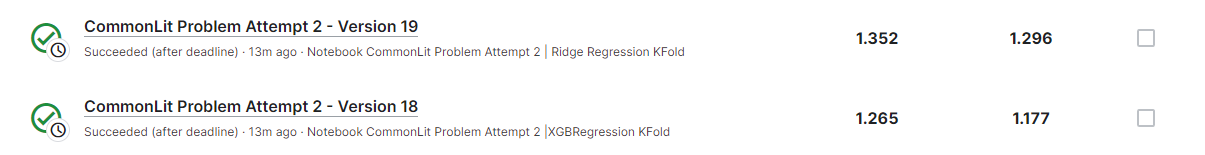

In [21]:
    groups = df_train['prompt_id']
    results = []
    test_results = []
    models = {"Ridgre Regression": [Ridge(),Ridge()],
              "XGBReregssor": [XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1), 
                               XGBRegressor(n_estimators = 80, learning_rate = 0.05, colsample_bytree = 0.4,gamma = 1)]
             }
    for model_name, model in models.items():
        scores = []
        
        vect = [TfidfVectorizer(analyzer='word',
                ngram_range=(1, 1),
                lowercase=True,
                min_df=1,
                max_features=30000),
                TfidfVectorizer(analyzer='word',
                        ngram_range=(1, 1),
                        lowercase=True,
                        min_df=1,
                        max_features=30000)]
        
        cv = GroupKFold(n_splits = 4)
        for  i, (train_ind, test_ind) in enumerate(cv.split(df_content, y_cont, groups)):
            X_cont_train, X_word_train, X_cont_test, X_word_test = df_content.iloc[train_ind], df_wording.iloc[train_ind], df_content.iloc[test_ind], df_wording.iloc[test_ind]
            y_cont_train, y_word_train, y_cont_test, y_word_test = y_cont.iloc[train_ind], y_wording.iloc[train_ind], y_cont.iloc[test_ind], y_wording.iloc[test_ind]

            vect[0].fit(X_cont_train['light_preprocess_text'])

            X_cont_train = vectorize_text_col(X_cont_train.reset_index(drop = True),"light_preprocess_text", vect[0])
            X_cont_test = vectorize_text_col(X_cont_test.reset_index(drop = True),"light_preprocess_text", vect[0])

            vect[1].fit(X_word_train['light_preprocess_text'])

            X_word_train  = vectorize_text_col(X_word_train.reset_index(drop = True), "light_preprocess_text", vect[1])
            X_word_test = vectorize_text_col(X_word_test.reset_index(drop=True), "light_preprocess_text", vect[1])

            model[0].fit(X_cont_train, y_cont_train)
            model[1].fit(X_word_train, y_word_train)

            cont_pred = model[0].predict(X_cont_test)
            word_pred = model[1].predict(X_word_test)

            scores.append(mcrmse(cont_pred, y_cont_test, word_pred, y_word_test))

        scores = np.array(scores)
        avg_score = round(scores.mean(), 4)
        std_score = round(scores.std(), 4)
        min_score = round(scores.min(), 4)
        max_score = round(scores.max(), 4)
        score_lower_bound = round(avg_score - 3*std_score, 4)
        score_higher_bound = round(avg_score + 3*std_score, 4)
        results.append({
            'experiment': model_name,
            'mcrmse_avg': avg_score,
            'mcrmse_std': std_score,
            'mcrmse_min': min_score,
            'mcrmse_max': max_score,
            'mcrmse_lower_bound_estimation': score_lower_bound,
            'mcrmse_higher_bound_estimation': score_higher_bound
        })

        df_test_cont_sub = vectorize_text_col(df_test_cont, "text", vect[0])
        df_test_word_sub = vectorize_text_col(df_test_word, "text", vect[1])

        cont_pred_test  = model[0].predict(df_test_cont_sub)
        word_pred_test = model[1].predict(df_test_word_sub)

        test_results.append(
                    {f"{model_name}_cont_pred":cont_pred_test,
                     f"{model_name}_word_pred":word_pred_test}
        )

    results = pd.DataFrame(results)

In [25]:
# df_ridge_sub = df_sample_submission.copy()
# df_ridge_sub['content'] = test_results[0]["Ridgre Regression_cont_pred"]
# df_ridge_sub['wording'] = test_results[0]["Ridgre Regression_word_pred"]
# df_ridge_sub.to_csv('submission.csv', index=False)

# df_xgbreg_sub = df_sample_submission.copy()
# df_xgbreg_sub['content'] = test_results[1]["XGBReregssor_cont_pred"]
# df_xgbreg_sub['wording'] = test_results[1]["XGBReregssor_word_pred"]
# df_xgbreg_sub.to_csv('submission.csv', index=False)

In [27]:
results

experiment  mcrmse_avg  mcrmse_std  mcrmse_min  mcrmse_max  \
0  Ridgre Regression      0.9238      0.0893      0.8199      1.0541   
1       XGBReregssor      0.7506      0.0797      0.6938      0.8881   

   mcrmse_lower_bound_estimation  mcrmse_higher_bound_estimation  
0                         0.6559                          1.1917  
1                         0.5115                          0.9897

Even from the first sight we can observe that MCRMSE has increased for all models and became closer to the result of real validation
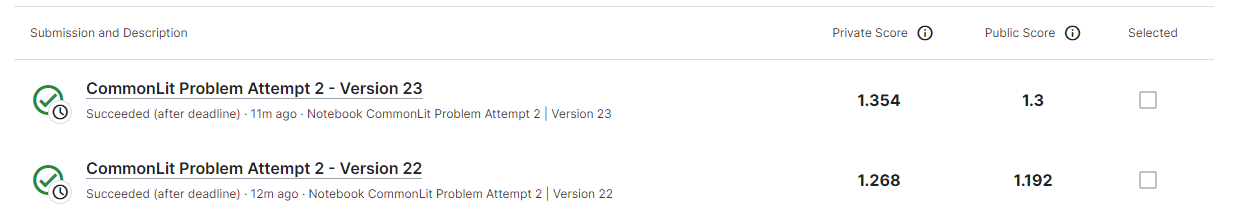
So we have received results MCRMSE similar to the MCRMSE on the last step, but mainly with making closer validation scores of mcrmse to the real metric value we have saved the correlations of metrics increases between experiments. But what haven't changed from the another steps is that metrics on LB is out of range of lower and higher bound estimation

Important Note version 22 is submission of XGBRegressor result and version 23 is submission of Ridge Regression

In the end, I want to add that the best validation technique for this exercise is GroupKFold for the next reasons:
1) First of all on this validation technique, there is correlation of metrics between experiments, which can significantly help in choosing the best model for the problem 

2) Secondly, this metric has the lowest difference between LB scores and validatiobn scores, but nevertheless difference remain significant

3)Finally,this validation technique is closer one to the real scoring of the notebook, because host of the project said, that it will be big quantity of new prompt_id in the test dataset, so this validation try to simulate this scoring

However one drawback that relies to all notebooks is that it is big difference of absolute value metrics for LB and all validation technique. This problem can be connected to the model perfomance, or maybe wide diversity of the test dataset 